In [44]:
# Initialize Otter
import otter
grader = otter.Notebook("projB2.ipynb")

# Project B2: Spam/Ham Classification - Build Your Own Model

## Feature Engineering, Classification, and Cross-Validation
## Due Date: Thursday, April 25th, 11:59 PM PDT

You must submit this assignment to Gradescope by the on-time deadline, Thursday, April 25th, 11:59 PM. Please read the syllabus for the grace period policy. No late submissions beyond the grace period will be accepted. **We strongly encourage you to plan to submit your work to Gradescope several hours before the stated deadline.** This way, you will have ample time to reach out to staff for submission support. While course staff is happy to help you if you encounter difficulties with submission, we may not be able to respond to last-minute requests for assistance (TAs need to sleep, after all!).

Please read the instructions carefully when submitting your work to Gradescope. 

## Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the project, we ask that you **write your solutions individually**. If you do discuss the assignments with others, please **include their names** in the collaborators cell below.

**Collaborators**: *list collaborators here*

## Introduction
In this project, you will build and improve on the concepts and functions you implemented in Project B1 to create your own classifier to distinguish spam emails from ham (non-spam) emails. We will evaluate your work based on your model's accuracy and written responses in this notebook.

After this assignment, you should feel comfortable with the following:

- Using `sklearn` libraries to process data and fit classification models.
- Validating the performance of your model and minimizing overfitting.
- Generating and analyzing ROC curves.

## Content Warning
This is a **real-world** dataset —— the emails you are trying to classify are actual spam and legitimate emails. As a result, some of the spam emails may be in poor taste or be considered inappropriate. We think the benefit of working with realistic data outweighs these inappropriate emails, but we wanted to warn you at the beginning of the project so that you are made aware.

If you feel uncomfortable with this topic, **please contact your TA, the instructors, or reach out via the [Spring 2024 extenuating circumstances form](https://forms.gle/HFdpmHzBu1e7zcF2A).**

In [45]:
# Run this cell to suppress all FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Grading
Grading is broken down into autograded answers and free responses. 

For autograded answers, the results of your code are compared to provided and/or hidden tests.

For free response questions, readers will evaluate how well you answered the question and/or fulfilled the requirements of the question.

Question | Manual | Points
----|----|----
1a | Yes | 4
1b | Yes | 2
2 | No | 0
3a | No | 5
3b | No | 10
4 | Yes | 6
5 | Yes | 3
6a | Yes | 3
6b | Yes | 2
7ai | No | 1
7aii | Yes | 1
7bi | Yes | 1
7bii | Yes | 1
7c | Yes | 1
7d | Yes | 2
7e | Yes | 2
Total | 12 | 44

## Before You Start

For each question in the assignment, please write down your answer in the answer cell(s) right below the question. 

We understand that it is helpful to have extra cells breaking down the process of reaching your final answer. If you happen to create new cells below your answer to run code, **NEVER** add cells between a question cell and the answer cell below it. It will cause errors when we run the autograder, and it will sometimes cause a failure to generate the PDF file.

**Important note: The local autograder tests will not be comprehensive. You can pass the automated tests in your notebook but still fail tests in the autograder.** Please be sure to check your results carefully.

### Debugging Guide
If you run into any technical issues, we highly recommend checking out the [Data 100 Debugging Guide](https://ds100.org/debugging-guide/). This guide contains general questions about Jupyter notebooks / Datahub, Gradescope, common `pandas` errors, RegEx, visualizations, and more.

In [46]:
import numpy as np
import pandas as pd
import sys

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

from datetime import datetime
from IPython.display import display, HTML

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Setup and Recap

Here, we will provide a summary of Project B1 to remind you of how we cleaned the data, explored it, and implemented methods helpful in building your own model.

## Loading and Cleaning Data

Remember that in the email classification task, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8,348 labeled examples, and the unlabeled test set contains 1,000 unlabeled examples.

Run the following cell to load the data into a `DataFrame`.

The `train` `DataFrame` contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example.
1. `subject`: The subject of the email.
1. `email`: The text of the email.
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam).

The `test` `DataFrame` contains 1,000 unlabeled emails. You will predict labels for these emails and submit your predictions to the autograder for evaluation.

In [47]:
import zipfile
with zipfile.ZipFile('spam_ham_data.zip') as item:
    item.extractall()

In [48]:
original_training_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Convert the emails to lowercase as the first step of text processing.
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


Feel free to explore the dataset above along with any specific spam and ham emails that interest you. Keep in mind that our data may contain missing values, which are handled in the following cell.

In [49]:
# Fill any missing or NAN values.
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


## Training/Validation Split

Recall that the training data we downloaded is all the data we have available for both training models and **validating** the models that we train. Therefore, we split the training data into separate training and validation datasets. Once you have finished training, you will need this validation data to assess the performance of your classifier. 

As in Project B1, we set the seed (`random_state`) to 42. **Do not modify this in the following questions, as our tests depend on this random seed.**

In [50]:
# This creates a 90/10 train-validation split on our labeled data.
from sklearn.model_selection import train_test_split
train, val = train_test_split(original_training_data, test_size = 0.1, random_state = 42)

# We must do this in order to preserve the ordering of emails to labels for words_in_texts.
train = train.reset_index(drop = True)

## Feature Engineering

We need a numeric feature matrix $\mathbb{X}$ and a vector of corresponding binary labels $\mathbb{Y}$ to train a logistic regression model. In Project B1, we implemented the function `words_in_texts`, which creates numeric features derived from the email text and uses those features for logistic regression. 

For this project, we have provided you with an implemented version of `words_in_texts`. Remember that the function outputs a 2-dimensional `NumPy` array containing one row for each email text. The row should contain a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. 

Run the following cell to see how the function works on some text.

In [51]:
from projB2_utils import words_in_texts

words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

## EDA and Basic Classification

In Project B1, we visualized the frequency of different words in spam and ham emails and used `words_in_texts(words, train['email'])` to train a classifier directly. We also provided a simple set of 5 words that might be useful as features to distinguish spam/ham emails. 

We then built a model using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier from `sklearn`.

Run the following cell to see the performance of a simple model using these words and the `train` `DataFrame`.

In [52]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['spam'])

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 array([0, 0, 0, 0, 0]))

In [53]:
from sklearn.linear_model import LogisticRegression

simple_model = LogisticRegression()
simple_model.fit(X_train, Y_train)

training_accuracy = simple_model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


## Evaluating Classifiers

In our models, we evaluate the accuracy of the training set, which may provide a misleading accuracy measure. In Project B1, we calculated various metrics to consider other ways of evaluating a classifier, in addition to overall accuracy. Below is a reference to those concepts.

Presumably, our classifier will be used for **filtering**, or preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- **False positive (FP)**: A ham email gets flagged as spam and filtered out of the inbox.
- **False negative (FN)**: A spam email gets mislabeled as ham and ends up in the inbox.

To be clear, we label spam emails as 1 and ham emails as 0. These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier in addition to overall accuracy:

**Precision**: Measures the proportion of emails flagged as spam that are actually spam. Mathematically, $\frac{\text{TP}}{\text{TP} + \text{FP}}$.

**Recall**: Measures the proportion  of spam emails that were correctly flagged as spam. Mathematically, $\frac{\text{TP}}{\text{TP} + \text{FN}}$.

**False positive rate**: Measures the proportion  of ham emails that were incorrectly flagged as spam. Mathematically, $\frac{\text{FP}}{\text{FP} + \text{TN}}$.

The below graphic (modified slightly from [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)) may help you understand precision and recall visually:<br />
<center>
<img alt="precision_recall" src="precision_recall.png" width="600px;" />
</center>

Note that a True Positive (TP) is a spam email that is classified as spam, and a True Negative (TN) is a ham email that is classified as ham.

<br/>
<hr style="border: 1px solid #fdb515;" />

# Moving Forward

With this in mind, it is now your task to make the spam filter more accurate. To get full credit on the accuracy part of this assignment, you must get at least **85%** accuracy on both the train and test set (see Question 3 for the partial credit breakdown). To determine your accuracy on the test set, you will use your classifier to predict every email in the `test` `DataFrame` and upload your predictions to Gradescope.

**You will only be able to submit your test set predictions to Gradescope up to 4 times per day**. You will be able to see your accuracy on the entire test set when submitting to Gradescope. Note that attempts will not carry over across days, so we recommend planning ahead to make sure you have enough time to finetune your model! In the case that you are approved for an extension, you are granted 4 more submissions for each day the deadline has been extended.

Here are some ideas for improving your model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject/body
    1. Number of words in the subject/body
    1. Use of punctuation (e.g., how many '!'s were there?)
    1. Number/percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. Alternatively, you can identify misclassified emails and see which relevant words are missing in your model.
1. Reducing dimensionality and/or multicollinearity. There are a few methods to achieve this:
    1. Implement PCA. Lectures [24](https://ds100.org/sp24/lecture/lec24/) and [25](https://ds100.org/sp24/lecture/lec25/) may be helpful.
    1. Interpret the model coefficients. Note that a feature will be more valuable in classification if its coefficient has a larger **absolute** value. If the coefficient has a lower **absolute** value, the feature likely isn't valuable in classifying emails.
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust the parameters of your model (e.g. the penalty type, the regularization parameter, or any arguments in `LogisticRegression`) to achieve higher accuracy. Recall that you should use cross-validation for feature and model selection! Otherwise, you will likely overfit to your training data.
    1. Consider implementing L1 regularization. The [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for `LogisticRegression` may be helpful here. 
    1. We have imported `GridSearchCV` for you. You may use sklearn's `GridSearchCV` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)) class to perform cross-validation. You do not need to code cross-validation from scratch, though you are welcome to do so.

Here's an example of how to use `GridSearchCV`. Suppose we wanted to experiment with 4 different solvers (numerical methods for optimizing the mode) models for a `LogisticRegression` model `lr_model`. 
1. We could define a dictionary specifying the hyperparameters and the specific values we want to try out like so: `parameters = {'solver':[{'lbfgs', 'liblinear', 'newton-cg', 'saga']}`.
2. Running `grid = GridSearchCV(estimator=lr_model, param_grid=parameters)` would give us a model for each combination of hyperparameters we are testing - in this case, just 4 models.
3. We fit each model to some training data `X_train` and `Y_train` using `grid_result = grid.fit(X_train, Y_train)`.
4. Indexing into `grid_result.cv_results_` with a particular metric (in this case, `mean_test_score`), we get an array with the scores corresponding to each of the models. `grid_result.cv_results_['mean_test_score']`.
Feel free to experiment with other hyperparameters and metrics as well. The documentation is your friend!     
       
You may use whatever method you prefer to create features, but **you may only use the packages we've imported for you in the cell below or earlier in this notebook**. In addition, **you are only allowed to train logistic regression models**. No decision trees, random forests, k-nearest-neighbors, neural nets, etc. 

**Note 1:** You may want to use your **validation data** to evaluate your model and get a better sense of how it will perform on the test set. However, you may overfit to your validation set if you try to optimize your validation accuracy too much. Alternatively, you can perform cross-validation on the entire training set.

**Note 2:** If you see a `ConvergenceWarning`, increase the maximum number of iterations the model runs for by passing in a parameter, `max_iter`, into `LogisticRegression()`. This should get rid of the warning. For a longer discussion on why this warning appears, you might find [this StackOverflow post](https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter) helpful. Convergence of solvers is not in scope for Data 100, but by understanding what the error messages are saying, you can get some useful context on what to do in these situations.

<br/>
<hr style="border: 1px solid #fdb515;" />

# Question 1: Exploratory Data Analysis

To decide which features to use when building your model, it is helpful to conduct EDA. Show a visualization you used to select features for your model. 

Please include:

1. A plot showing something meaningful about the data that helped you during feature selection, model selection, or both.
2. Two or three sentences describing what you plotted and its implications with respect to your features.

You can create as many plots as you want in your feature selection process, but you should select only one for the response question below.

**You should not just produce an identical visualization to Question 3 in Project B1.** For this section, we’d like you to go beyond the analysis you performed in Project B1. Choose some plot other than the 1-dimensional distribution of some quantity for spam and ham emails. In particular, do not produce a bar plot of proportions like you created in Question 3 of Project B1. Any other plot is acceptable, **as long as it comes with thoughtful commentary.** Here are some ideas:

1. Consider the correlation between multiple features (look up correlation plots and `sns.heatmap` ([documentation](https://seaborn.pydata.org/generated/seaborn.heatmap.html))). 
1. Try to show redundancy in a group of features (e.g., `body` and `html` might co-occur relatively frequently, or you might be able to design a feature that captures all HTML tags and compares them to these). 
1. Visualize which words have high or low values for helpful statistics.
1. Visually depict whether spam emails tend to be wordier (in some sense) than ham emails.

<!-- BEGIN QUESTION -->

<br>

---

## Question 1a

Generate your visualization in the cell below.


<Axes: >

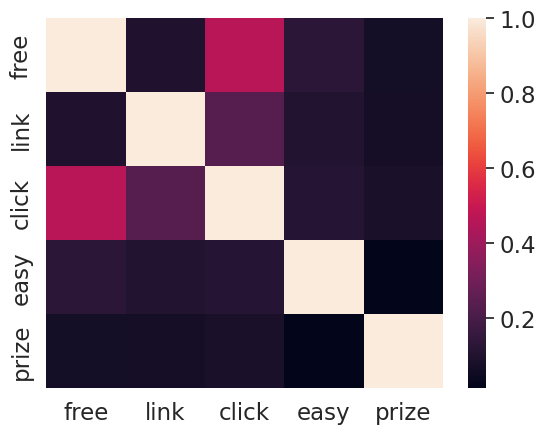

In [54]:
w_train = train
words = ['free', 'link', 'click', 'easy', 'prize']
w_train['free'] = words_in_texts(['free'], train['email'])
w_train['link'] = words_in_texts(['link'], train['email'])
w_train['click'] = words_in_texts(['click'], train['email'])
w_train['easy'] = words_in_texts(['easy'], train['email'])
w_train['prize'] = words_in_texts(['prize'], train['email'])

corr = w_train[words]

sns.heatmap(corr.corr())

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

---

## Question 1b

In two to three sentences, describe what you plotted and its implications with respect to your features.

What I plotted was a heatmap with the correlations a 5 different words I plan to use for my features. The implication that these have is that if they have high correlation it would mean they can be similarly used to classifyb something as spam for the purposes of this project. 

<!-- END QUESTION -->

<br/>
<hr style="border: 1px solid #fdb515;" />

# Question 2: Building Your Own Model

Now that you've explored the data and relevant features through EDA, it's time to build your model! As mentioned earlier, you may use whatever method you prefer to create features, but **you may only use the packages we've imported for you in the cell below or earlier in this notebook**. In addition, **you are only allowed to train logistic regression models**. No decision trees, random forests, k-nearest-neighbors, neural nets, etc. 

Please consider the ideas mentioned above when choosing features. We have not provided any code to do this, so feel free to create as many cells as you need to tackle this task. 

In [55]:
# import libraries
# You may use any of these to create your features.
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import re
from collections import Counter

In [56]:
# Define your processing function, processed data, and model here. 
# You may find it helpful to look through the rest of the questions first!
model_words = ['free', 'link', 'click', 'easy', 'prize', 'urgent', 'call', 'discount', 'friend', 'double', 
               'drug', 'bank', 'prescription', 'memo', 'private', 'refund', 'win', '<html>', '$', '$$$', 
               '<head>', '<\n>', 'bonus', 'congratulations', 'please', 'money']

X_train = words_in_texts(model_words, train['email'])
Y_train = train['spam']

X_value = words_in_texts(model_words, val['email'])
Y_value = val['spam'].values

X2_test = words_in_texts(model_words, test['email'])

model = LogisticRegression()
model.fit(X_train, Y_train)

train_acc = model.score(X_train, Y_train)

print('training score:', train_acc)

training score: 0.8649008385465193


In [57]:
original_training_data.head(10)

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0
5,5,Subject: Five\n,url: http://diveintomark.org/archives/2002/10/...,0
6,6,Subject: [SAdev] [Bug 1006] Spamassassin's bui...,http://www.hughes-family.org/bugzilla/show_bug...,0
7,7,Subject: One of a kind Money maker! Try it for...,------000000000000000000000\n content-type: te...,1
8,8,Subject: freshrpms.net resources (was Re: use ...,"once upon a time, brian wrote :\n \n > yeah...",0
9,9,Subject: use of base image / delta image for a...,"hi,\n \n i was inspired by a mode of operation...",0


<br>

---

# Question 3

### Grading Scheme

Your grade for this question will be based on your model’s accuracy when making predictions on the training set and your model’s accuracy when making predictions on the test set. The tables below provide scoring guidelines. If your accuracy lies in a particular range, you will receive the number of points associated with that range.

**Important**: While your training accuracy can be checked at any time in this notebook, your test accuracy can only be checked by submitting your model’s predictions to Gradescope. **You will only be able to submit your test set predictions to Gradescope up to 4 times per day**. In the case that you are approved for an extension, you are granted 4 more submissions for each day the deadline has been extended. Plan ahead to make sure you have enough time to fine-tune your model! The thresholds are as follows:

Points | 5 | 3 | 1.5 | 0
--- | --- | --- | --- | ---
**Training** Accuracy | 85% and Above | \[80, 85) | \[70, 80) | Below 70%

Points | 10 | 6 | 3 | 0
--- | --- | --- | --- | ---
**Testing** Accuracy | 85% and Above | \[80, 85) | \[70, 80) | Below 70%


<br><br>

---

## Question 3a: Train Predictions
Assign your predictions for the class of each data point in the training set `train` to `train_predictions`.

In [58]:
train_predictions = model.predict(X_train)

# Print your training accuracy. 
training_accuracy = np.mean(train_predictions == train["spam"])
training_accuracy

0.8649008385465193

In [59]:
grader.check("q3a")

q3a results: All test cases passed!

<br>

---

## Question 3b: Test Predictions

The following code will write your predictions on the test dataset to a CSV file. **You will need to submit this file to the "Project B2 Test Set Predictions" assignment on Gradescope to get credit for this question.**

Assign your predictions for the class of each datapoint in the test set `test` to a 1-dimensional array called `test_predictions`. **Please make sure you save your predictions to `test_predictions`, as this is how part of your score for this question will be determined.**

**Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions.** For example, if you've created features for the words "drug" and "money" on the training data, you must also extract the same features in order to use `scikit-learn`'s `.predict` method.

**Gradescope limits you to 4 submissions per day to meet the threshold.** If you are approved for an extension, you are granted 4 more submissions for each day the deadline has been extended.

The provided tests check that your predictions are in the correct format but are worth 0 points in the *Project B2 Coding assignment*. To evaluate your classifier accuracy, you must submit the CSV file to the *Project B2 Test Set Predictions* assignment.

In [60]:
test_predictions = model.predict(X2_test)

In [61]:
grader.check("q3b")

q3b results: All test cases passed!

The following cell generates a CSV file with your predictions. **You must submit this CSV file to the "Project B2 Test Set Predictions" assignment on Gradescope to get credit for this question.** You can only submit to Gradescope a maximum of 4 times per day, so please use your submissions wisely!

In [62]:
# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = "submission_{}.csv".format(timestamp)
submission_df.to_csv(filename, index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
display(HTML("Download your test prediction <a href='" + filename + "' download>here</a>."))
print('You may now upload this CSV file to Gradescope for scoring.')#

Created a CSV file: submission_20240426_175126.csv.


You may now upload this CSV file to Gradescope for scoring.


<br/>
<hr style="border: 1px solid #fdb515;" />

# Analyzing Your Model

Congratulations on completing your model! In the next few questions, we'll ask you to comment on your process for building a successful model and better understand the amount of misclassifications your model makes. 

<!-- BEGIN QUESTION -->

<br>

---

# Question 4

Describe the process of improving your model. You should use at least 2-3 sentences each to address the following questions:

1. How did you find better features for your model?
2. What did you try that worked or didn't work?
3. What was surprising in your search for good features?

1. What I did to find better features in my model was to first look into the various emails and find words that I thought cried out spam to me. The next methodology was to consider my own real-life experience and think about what common words I have encountered with actual spam words in my own inbox.
2. What I tried that worked was creating a similar model from that of projectb1 as it allowed for simplicity in building up the accuracy. What didnt work for me was just using a few amount of words and my model would under-predict and the accuracy score would be low.
3. What was suprising for good features is how valuable is our own lived experiences when choosing the words. If I hadnt had prior experiences ith= would be hard for me to know which words to choose for my model. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

---

# Question 5: ROC Curve

In most cases, we won't be able to get 0 false positives and 0 false negatives, so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover that they have cancer until it's too late. In contrast, a patient can receive another screening for a false positive.

Recall that logistic regression calculates the probability that an example belongs to a particular class. To classify an example, we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, **we can adjust that cutoff threshold**. We can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The Receiver Operating Characteristic (ROC) curve shows this trade-off for each possible cutoff probability. In the cell below, plot an ROC curve for your final classifier (the one you use to make predictions for Gradescope) on the training data. [Lecture 23](https://ds100.org/sp24/lecture/lec23/) may be helpful.

**Hint**: You'll want to use the `.predict_proba` method [(documentation)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba) for your classifier instead of `.predict` to get probabilities instead of binary predictions.

Text(0.5, 1.0, 'Roc_Curve_graph')

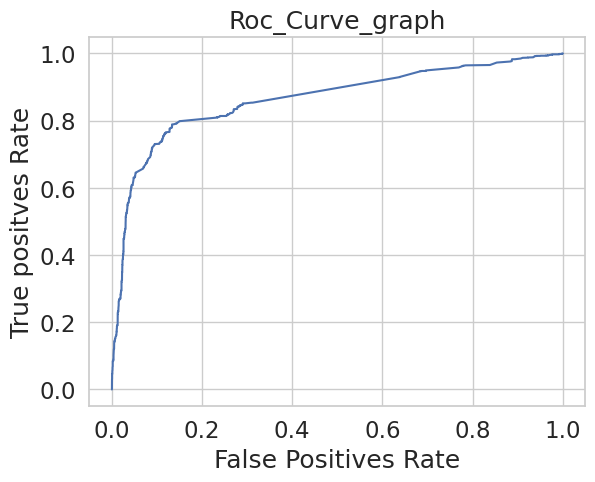

In [63]:
proba = model.predict_proba(X_train)[:,1]
fp, tp, thresholds = roc_curve(Y_train, proba)
plt.plot(fp, tp)
plt.xlabel('False Positives Rate')
plt.ylabel('True positves Rate')
plt.title('Roc_Curve_graph')

<!-- END QUESTION -->

<br/>
<hr style="border: 1px solid #fdb515;" />

# Diving Deeper

So far, we’ve been looking at our model through the lens of accuracy. In the next two questions, we'll dive deeper into the complexities of analyzing our model's performance. In particular, we'll ask you to explore some ambiguous cases that can arise, even within the training data itself, and the consequences of misclassification. You may have already come across some of these cases unknowingly when building your model!

<br><br>

---

## Question 6

To help you better understand some of the challenges that arise with classification, we've selected three emails from the `train` `DataFrame` and provided them below. Each email highlights a different issue that could arise. Skim through each of the emails below before answering part a).

### Example 1

In [64]:
# Just run this cell, don't modify it.

print("spam: " + str(train.loc[5216]["spam"]))
print("\nemail:\n" + train.loc[5216]["email"])

spam: 1

email:
hello you two,
 
 i am so sorry catherine for not writing recently. i have just been vv busybeing a working mother and sometimes it all gets too much you know!! i cannot wait to see you both although we may meet at the airport on the 16/6 as that's the day we're going to france but i will see you both at bronagh's house for her 30th which we're going to on the way back from the airport. i am so excited about seeing you!!! liitle eva ( aine) was born on tuesday
  she is absolutely incredible. poor bronagh is 11 dsays over!!
 sounds like you've been having an amazing time. hope you won't be too depressed to be back!!
 
 lots of love
 
 deirdre
 "justin mason" <jm@jmason.org> wrote:
 
 <  
 <  just a quick note -
 <  
 <  we've decided to go up to annapurna base camp instead of
 <  the jomsom trek - it's a bit more impressive visually
 <  (if a little soggier).   so as of tomorrow morning, ourselves
 <  and our guide bhadra will be leaping like gazelles up 4000-odd
 <  met

### Example 2

In [65]:
# Just run this cell, don't modify it.

print("spam: " + str(train.loc[36]["spam"]))
print("\nemail:\n" + train.loc[36]["email"])

spam: 0

email:
lifetime movie newsletter
 
 this week's movies to watch on lifetime
 
 [ http://www.lifetimetv.com/movies/index.html ]
 
 august 19, 2002
 
 *************************************************************************
 
 coming at you this week...
 
 1) "the secret life of zoey" premiere!
 2) the buzz about the upcoming movie
 3) movies airing this week
 4) big event: a martinez sunday
 5) fun and games
 
 *************************************************************************
 
 "the secret life of zoey" premiere!
 
 take a sneak peek at lifetimes next exciting original movie, "the secret life of zoey" [ http://www.lifetimetv.com/movies/info/move3195.html ], airing on monday, august 19 at 9 pm et/pt. zoey's mom thought she knew everything about her perfect teenage daughter. but when she realizes that her child is addicted to drugs, both of their worlds spin out of control. this dramatic film delves into the topic of teenage drug addiction and features stellar performer

### Example 3

In [66]:
# Just run this cell, don't modify it.

print("spam: " + str(train.loc[1092]["spam"]))
print("\nemail:\n" + train.loc[1092]["email"])

spam: 0

email:
this is a multi part message in mime format.
 
 --_nextpart_1_bvfoditvghtocxfdvjnkcuwblfv
 content-type: text/plain; charset="us-ascii"
 content-transfer-encoding: 7bit
 
 ........... with our telecoms partner bumblebee !
 
 don't get ripped off by expensive hotel, payphone and mobile charges. 
 save, save, save on international calls with ryanair's phone partner. 
 ************************************************************************
 *********
 
 you'll save up to 70% on international phone calls when you use our 
 online phone card.  you can use the card from any phone in any country 
 you visit and you won't have to worry about high phone charges 
 when you call home or the office.
 
 buying a card couldn't be easier and it's totally secure.  simply go to
 http://www.bumblebeecommunications.com/lowcostcalls/  
  to avail of this special offer for ryanair customers.
 
 it's another great deal from ryanair and our online phone 
 partner, bumblebee communications. 


<!-- BEGIN QUESTION -->

### Question 6a

Pick at least **one** of the emails provided above to comment on. How would you classify the email (e.g., spam or ham), and does this align with the classification provided in the training data? What could be a reason someone would disagree with *your* classification of the email? In 2-3 sentences, explain your perspective and potential reasons for disagreement.

I choose email 2 and my model will classify it as spam. And this indeed aligns with the provided training data given it has a lot of the words I used in my model. Someone can disagree with my classification as they might argue that my model allows for a lot of false positives as at times words arnt the best indicator of spam. Although this is true we can all agree that there is certain words that are commonly seen and used in spam emails therefore I have confidence in my classification, as the words I choose werent at random.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6b

As data scientists, we sometimes take the data to be a fixed “ground truth,” establishing the “correct” classification of emails. However, as you might have seen above, some emails can be ambiguous; people may disagree about whether an email is actually spam or ham. How does the ambiguity in our labeled data (spam or ham) affect our understanding of the model's predictions and the way we measure/evaluate our model's performance?

The issue with having the labels spam or ham is its do black and white. Meaning we dont allow for grey responsed, what I mean by that is that there is chance in the real world of results in our case emails classified either as spam or ham not to be one or the other. We have to allow for ambiguity within our classification.

<!-- END QUESTION -->

As a data scientist, we encourage you to think more critically about your data before establishing it as the "ground truth." Whenever you're working on a specific problem, ask yourself:  
1. Who “made” the data? Think about all the stages from when it was first generated, collected, and labeled before it ended up in a CSV file.
2. What assumptions and biases are inherently present in the data?
3. And finally, how does all this affect how you interpret your model’s performance?

<br><br>

---

## Question 7

In Question 6, we explored the instability present in the “ground truth” and how this affects our evaluation of our model. Now, let's start thinking about your model's interpretability and what that means more broadly for an email classification task. A model is considered interpretable if humans can easily understand the reasoning behind its predictions and classifications.

### Question 7a

First, let's see if we can understand how our choice of features relates to how a particular email is classified. 

#### Part i

Let’s take a look at the `simple_model` we provided you earlier that uses 5 features. We have provided the code below for ease of reference. You will examine how a particular feature influences how an email is classified. 

In [67]:
# Simple model introduced at the start of this notebook. Just pay attention to the features.
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['spam'])

simple_model = LogisticRegression()
simple_model.fit(X_train, Y_train);

Pick an email from the training set and assign its index to `email_idx`. Then, find **one** feature used in `simple_model` such that **removing** it changes how that email is classified. Assign this feature to  `feature_to_remove`.

In [89]:
# Use this cell for scratch work when determining `email_idx`
train.loc[40,'email']

"attn:\n \n i am bulawa mulete jr. the son of mr. \n \n steve mbeki mulete from zimbabwe. i am sorry this mail\n will surprise you, though we do not know, \n due to the current war against white farmers in\n zimbabwe and the support of president robert mugabe to\n claim all white owned farms in our country to gain\n favor for re-election.\n \n all white farmers were asked to\n surrender their farms to the government for\n re-distribution and infact to his political party\n members and my father though black was the treasury\n of the farmers association and a strong member of an\n opposition party that did not support the president\n idea. he then ordered his party members and the police\n under his pay row to invade my father's farm and burn\n down everything in the farm. they killed my\n father and took away a lot of items from his farm.\n after the death of my father, our local pastor and a\n close friend of my father handed us over will\n documents with instructions from my father t

In [101]:
email_idx = 50

prob_spam = simple_model.predict_proba(X_train)[:, 1]
initial_prob = prob_spam[email_idx]
initial_class = "spam" if np.round(initial_prob) else "ham"
print(f"\nPredicted probability of being spam: {np.round(initial_prob*100, 2)}%")
print("\nEmail:\n" + train.loc[email_idx]["email"])


Predicted probability of being spam: 55.57%

Email:
<html>
 <head>
 <title>igtt</title>
 <meta http-equiv="content-type" content="text/html; charset=iso-8859-1">
 </head>
 <body bgcolor="#ffffff" text="#000000">
 <img src="http://www.developerhosting.com/lqtracker/imgtrk.asp?id=40165&uid=1290" width="1" height="1" border="0"> 
 <div align="center">
 <table width="92%" border="1" bordercolor="#333333">
 <tr> 
 <td height="23"> 
 <div align="center">
 <div align="center">
 <div align="center"> 
 <div align="center">
 <p align="right"><font color="#000000" size="2" face="courier new, courier, mono">vol. 
 6, issue 243 - august 2002</font></p>
 <p><font size="6"><font face="impact" size="7" color="#ff0000">the 
 wall street bulletin</font></font></p>
 </div>
 <div align="center"><font color="#ff0000"><i><font size="4" face="times new roman, times, serif"><b><font size="3">your 
 first source for news from &quot;the street&quot;</font></b></font></i></font></div>
 <p align="center">symbol:

In [106]:
feature_to_remove = 'bank'

changed_words = some_words.copy()
changed_words.remove(feature_to_remove)

changed_model = LogisticRegression()
X_changed = words_in_texts(changed_words, train['email'])
y = train['spam']
changed_model.fit(X_changed, y)
changed_prob = changed_model.predict_proba(X_changed[[email_idx]])[:,1][0]
changed_class = "spam" if np.round(changed_prob) else "ham"

print(f"Initially classified as {initial_class} (Probability: {np.round(initial_prob*100, 2)}%)")
print(f"Now classified as {changed_class} (Probability: {np.round(changed_prob*100, 2)}%)")

Initially classified as spam (Probability: 55.57%)
Now classified as ham (Probability: 24.33%)


In [107]:
grader.check("q7ai")

q7ai results: All test cases passed!

<!-- BEGIN QUESTION -->

#### Part ii

In 2-3 sentences, explain why you think the feature you chose to remove changed how your email was classified.

The feature I choose to remove changes how the email was classified because the entire email was about finances and revenues of different companies. Therefore by removing bank the word that was comonly  being used it no longer things its spam, by a grand margin of 50% deacrease. From %55% to %25.

<!-- END QUESTION -->

### Question 7b

Now, let's say that instead of working with a small model containing 50-100 features, you're working with a much larger, more accurate model containing 1000 features. 

<!-- BEGIN QUESTION -->

#### Part i
In this context, do you think you could easily find a feature that could change an email's classification as you did in part a)? Why or why not?

It would be harder to find a feature that can change the emails classification because theres so many words that changing one out of lests say 1000 wont do much if 100 of those words are found in the email. Thus the proportion would be smaller, therefore harder to classify.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Part ii 
Would you expect this new model to be more or less interpretable than `simple_model`?

**Note**: A model is considered interpretable if you can easily understand the reasoning behind its predictions and classifications. For example, the model we saw in part a), `simple_model`, is considered interpretable as we can identify which features contribute to an email's classification.

It would be less inerpretable because it would be hard to understand just from looking at it why they choose those particular words.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 7c

Now, imagine you’re a data scientist at Meta, developing a text classification model to decide whether to remove certain posts / comments on Facebook. In particular, you’re primarily working on moderating the following categories of content:
* Hate speech
* Misinformation 
* Violence and incitement

Pick one of these types of content to focus on (or if you have another type you’d like to focus on, feel free to comment on that!). What content would fall under the category you’ve chosen? Refer to Facebook’s [Community Standards](https://transparency.fb.com/policies/community-standards/), which outline what is and isn’t allowed on Facebook. 

The content that would fall under the content of voilence and incitement is any form of speech that invites the hurt / encourages danger against a certain group of people/race/minority group.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 7d

What are the stakes of misclassifying a post in the context of a social media platform? Comment on what a false positive or false negative means for the category of content you’ve chosen (hate speech, misinformation, or violence and incitement).

There is huge danger in false negatives for violence and incitement as if we are unable to catch it, we might actually have violence occur within the real world and people can get hurt. I think for this false positives arnt to bad given the scale of what it implies.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 7e

As a data scientist, why might having an interpretable model be useful when moderating content online?

Its useful because it allows for users of your platform to understand what is allowed. And on a legal perspective it gives you the 

<!-- END QUESTION -->

As you explored throughout this question, interpretability is incredibly important. However, it is equally important to note that interpretability on its own isn’t a fix to all the problems that may arise when moderating content or when building a model more generally. As we touched on in Project A2, these models don’t operate in a vacuum; they exist in a wider sociotechnical system. Everything from the data used to train these models to the metrics we choose to evaluate our models builds on that notion.

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Mimi and Trouble congratulate you for finishing Project B2!

<div align="middle">
    <table style="width:75%">
      <tr align="center">
        <td><video controls src = "images/mimi.mp4" width = "250">animation</video>
        <td><img src="images/trouble2.jpeg" align="middle" width="325vw"/>
        <td><img src="images/trouble.jpeg" align="middle" width="325vw"/>
      </tr>
    </table>
  </div>

### Course Content Feedback

If you have any feedback about this assignment or about any of our other weekly, weekly assignments, lectures, or discussions, please fill out the [Course Content Feedback Form](https://docs.google.com/forms/d/e/1FAIpQLSe0fBEJwt6aEfZxU3fh3llNk8rSWHj6Umq0km3wPqmFu0MlGA/viewform). Your input is valuable in helping us improve the quality and relevance of our content to better meet your needs and expectations!

### Submission Instructions

Below, you will see a cell. Running this cell will automatically generate a zip file with your autograded answers. Once you submit this file to the Project B2 Coding assignment on Gradescope, Gradescope will automatically submit a PDF file with your written answers to the Project B2 Written assignment. If you run into any issues when running this cell, feel free to check this [section](https://ds100.org/debugging-guide/autograder_gradescope/autograder_gradescope.html#why-does-grader.exportrun_teststrue-fail-if-all-previous-tests-passed) in the Data 100 Debugging Guide.

If there are issues with automatically generating the PDF, you can try downloading the notebook as a PDF by clicking on `File -> Save and Export Notebook As... -> PDF`. If that doesn't work either, you can manually take screenshots of your answers to the manually graded questions and submit those. 

**Please make sure you submit the following to the right assignments:**

* **Project B2 Coding:** Submit the zip file generated by using the `grader.export()` cell provided below.
* **Project B2 Written:** Gradescope will automatically submit the PDF from the zip file submitted earlier. You do not need to submit anything to this assignment yourself, but *please check that the submission went through properly and that all plots rendered correctly*.
* **Project B2 Test Set Predictions:** Submit the CSV file generated in `q3b`.

**You are responsible for ensuring your submission follows our requirements and that everything was generated and submitted correctly. We will not be granting regrade requests nor extensions to submissions that don't follow instructions.** If you encounter any difficulties with submission, please don't hesitate to reach out to staff prior to the deadline. 

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)